# Preface

In this notebook, we implement a simple Q-learning algorithm to solve the (in)famous handphone game [*Flappy Bird*](https://en.wikipedia.org/wiki/Flappy_Bird)

The main takeaways are
  * Implementation of Q-learning
  * Using the Python Learning Environment (PLE)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Nice progress bar, optional

We have to first install the PyGame Learning Environment. Installation instructions can be found at the [Github Repository](https://github.com/ntasfi/PyGame-Learning-Environment)

In [3]:
from ple.games.flappybird import FlappyBird
from ple import PLE
np.random.seed(123)  # For Reproducibility

First, we make the game environment and the PLE environment that will be driving the game.

In [4]:
game_env = FlappyBird()
ple_env = PLE(game_env, fps=30, display_screen=True)

Let us explore the game interface

In [5]:
ple_env.init()  # initalizes the game state

The `getGameState()` method obtains a dictionary describing the state of the game. This forms the basis of the state description $s$ that will be used in our reinforcement learning algorithm.

In [6]:
game_env.getGameState()

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

The current score can be obtained by the `score()` method

In [7]:
ple_env.score()

0.0

The available action set is obtained by the `getActionSet`

In the case of Flappy Bird, the actions are
* 119: press up (jump)
* None: do nothing

In [7]:
ple_env.getActionSet()

[119, None]

We can play the game by supplying an input action taken from the action set, by calling the `act()` method. The method returns the current score.

In [8]:
ple_env.act(action=None)

0.0

The status of the game can be queried by the game_over() method

In [9]:
ple_env.game_over()

False

# Environment/Reward Parsers

Now, we apply reinforcement learning on this problem. 

The first step will be deciding a suitable state representation.

The raw state is returned by `getGameState()`, which has a lot of information:

```python
print(game_env.getGameState())

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 53,
 'next_pipe_bottom_y': 153,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 153,
 'next_next_pipe_bottom_y': 253}
```

We will take 3 relevant features from these descriptions
1. The distance to next pipe
2. The height difference between the top pipe and bird
3. The height difference between the bird and bottom pipe

For each of these features, we will bin and summarize the state as one of the possible bins.
For example, the heigh difference between the top pipe and bird can be any value between -512, and 512. Hence, we will bin these values into bins of width `bin_size`, which results in a total of `1024//bin_size` possible states for this feature.

In [10]:
bin_size = 10
n_bins_dist = np.ceil(350 / bin_size).astype('int')
n_bins_top = np.ceil(1024 / bin_size).astype('int')
n_bins_bot = np.ceil(1024 / bin_size).astype('int')

We write the follow function that converts a raw game state into one with the above three features.

In [11]:
def parse_state(game_state):
    state = np.zeros((3, ), dtype=int)
    state[0] = game_state['next_pipe_dist_to_player'] // bin_size
    state[1] = (game_state['next_pipe_top_y'] - game_state['player_y'] +
                512) // bin_size
    state[2] = (game_state['next_pipe_bottom_y'] - game_state['player_y'] +
                512) // bin_size
    return state

In [12]:
game_state = game_env.getGameState()
game_state

{'player_y': 248.0,
 'player_vel': -8.0,
 'next_pipe_dist_to_player': 305.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 449.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

In [13]:
parse_state(game_state)

array([30, 40, 50])

We also need some parser for the reward, since the score need not be the actual reward/return we feed into our RL algorithm.

For example, in this case we saw that the `score()` method returns -5 if the game is lost, +1 for every pipe passed and 0 otherwise.

We will modify this so that we return +1 for each time we do not hit a pipe and  -100 if we hit the pipe or floor.

**Remark.** Do experiment with different reward definitions!

In [14]:
def parse_reward(game_reward):
    return 1.0 if game_reward>= 0 else -100.0

# Q-Learning

We now implement Q-Learning.

The $Q$ function (action-value function) is now regarded as a tensor with dimensions

    [n_bins_dist, n_bins_top, n_bins_bot, 2]

where the first 3 dimensions describes the state and the last dimension describes the action. The first action is 

We first implement a action choice function which picks an action deterministically based on the Bellman's optimality principle:
$$
    \pi(s) = \mathrm{arg\,max}_a Q(s, a)
$$

In [15]:
def choose_action(state, Q):
    q_up, q_nothing = Q[tuple(state)]
    return 0 if q_up > q_nothing else 1

action_dict = {0: 119, 1: None}

Now, we write a function to update the Q matrix, according to the usual Q learning formula

$$
    Q(s,a)
    \leftarrow
    (1-\alpha) \underbrace{Q(s,a)}_{Q_{\text{old}}}
    +
    \alpha
    [
        \underbrace{r + \gamma \max_{a'} Q(s', a')}_{Q_{\text{new}}}
    ]
$$

In [16]:
def update_Q(Q, state, next_state, action, reward, alpha, gamma):
    Q_new = reward + gamma * np.max(Q[tuple(next_state)])
    Q_old = Q[tuple(state)][action]
    Q[tuple(state)][action] = (1 - alpha) * Q_old + alpha * Q_new

We initialize Q as all zeros and train using Q learning

In [17]:
Q = np.zeros((n_bins_dist, n_bins_top, n_bins_bot, 2))

In [18]:
scores = []
returns = []
alpha = 0.1
gamma = 0.99

In [19]:
n_epochs = 1000

for _ in tqdm(range(n_epochs)):
    ple_env.init()
    state = parse_state(game_env.getGameState())
    cumulative_reward = 0.0
    
    while not ple_env.game_over():
        # Sample action
        action = choose_action(state, Q)
        
        # Evolve state and parse reward
        game_reward = ple_env.act(action_dict[action])
        reward = parse_reward(game_reward)
        next_state = parse_state(game_env.getGameState())
        
        # Update Q function
        update_Q(Q, state, next_state, action, reward, alpha, gamma)
        cumulative_reward += reward
        state = next_state
        time.sleep(0.01)  # Comment out if no need to visualize
    
    scores.append(ple_env.score())
    returns.append(cumulative_reward)

100%|██████████| 1000/1000 [21:44<00:00,  1.30s/it]


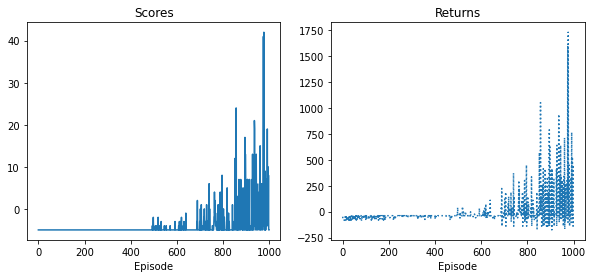

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax0.plot(scores, '-')
ax1.plot(returns, ':')

ax0.set_title('Scores')
ax1.set_title('Returns')

for ax in (ax0, ax1):
    ax.set_xlabel('Episode')

**Exercise**

Try to improve the performance by, e.g.
1. Changing the reward function
2. Changing the initialization
3. Changing how the state is parsed